📘 PatchTST for IoT Time Series Forecasting

PatchTST treats a time series like an image:
	•	Splits the series into small “patches” 🔲
	•	Embeds them like tokens
	•	Uses a pure Transformer (no convolutions or recurrence!)

This makes PatchTST extremely strong on long sequence forecasting.

In [9]:
# 📦 Step 1: Import Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [10]:
# 📂 Step 2: Load Preprocessed Data
df = pd.read_csv("../data/processed/etth1_processed.csv", parse_dates=["date"], index_col="date")
target = df["OT"].values

In [11]:
# 🧩 Step 3: Create Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window_size, patch_size):
        self.series = torch.tensor(series, dtype=torch.float32)
        self.window_size = window_size
        self.patch_size = patch_size

    def __len__(self):
        return len(self.series) - self.window_size

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size]
        y = self.series[idx+self.window_size]
        patches = rearrange(x, '(p s) -> p s', s=self.patch_size)
        return patches.unsqueeze(-1), y

In [12]:
# 🔄 Step 4: Dataloader
window_size = 96  # Should be divisible by patch_size
patch_size = 8    # 96/8 = 12 patches
batch_size = 32
dataset = TimeSeriesDataset(target, window_size, patch_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# 🧠 Step 5: PatchTST Model
class PatchTST(nn.Module):
    def __init__(self, patch_size=8, d_model=64, n_heads=4, num_layers=2, num_patches=12):
        super().__init__()
        self.patch_embed = nn.Linear(patch_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch, patches, patch_size, 1]
        x = x.squeeze(-1)   # [batch, patches, patch_size]
        x = self.patch_embed(x)  # [batch, patches, d_model]
        x = self.transformer(x)
        x = x.mean(dim=1)   # average over patches
        return self.head(x)

In [14]:
# ⚙️ Step 6: Train the PatchTST Model
model = PatchTST(patch_size=patch_size, num_patches=window_size//patch_size).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), '../models/checkpoints/patchTST_transformer_model.pth')

Epoch 1 | Loss: 0.0275
Epoch 2 | Loss: 0.0039
Epoch 3 | Loss: 0.0037
Epoch 4 | Loss: 0.0037
Epoch 5 | Loss: 0.0037
Epoch 6 | Loss: 0.0034
Epoch 7 | Loss: 0.0034
Epoch 8 | Loss: 0.0033
Epoch 9 | Loss: 0.0031
Epoch 10 | Loss: 0.0031


In [15]:
# Evaluation
model.eval()
predictions = []
true_values = []
with torch.no_grad():
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        predictions.append(pred.cpu().numpy())
        true_values.append(y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# Inverse transform predictions and true values
# Add dummy columns to match the scaler's expected input shape
dummy_shape = (predictions.shape[0], df.shape[1])  # Match the number of columns in the original data
predictions_full = np.zeros(dummy_shape)
true_values_full = np.zeros(dummy_shape)

# Fill the relevant column (e.g., 'OT') with predictions and true values
predictions_full[:, -1] = predictions.flatten()
true_values_full[:, -1] = true_values.flatten()

# Apply inverse transform
scaler = MinMaxScaler()
scaler.fit(df)  # Fit scaler on the original dataframe
predictions = scaler.inverse_transform(predictions_full)[:, -1]  # Extract the 'OT' column
true_values = scaler.inverse_transform(true_values_full)[:, -1]  # Extract the 'OT' column

MSE: 0.0024, MAE: 0.0385


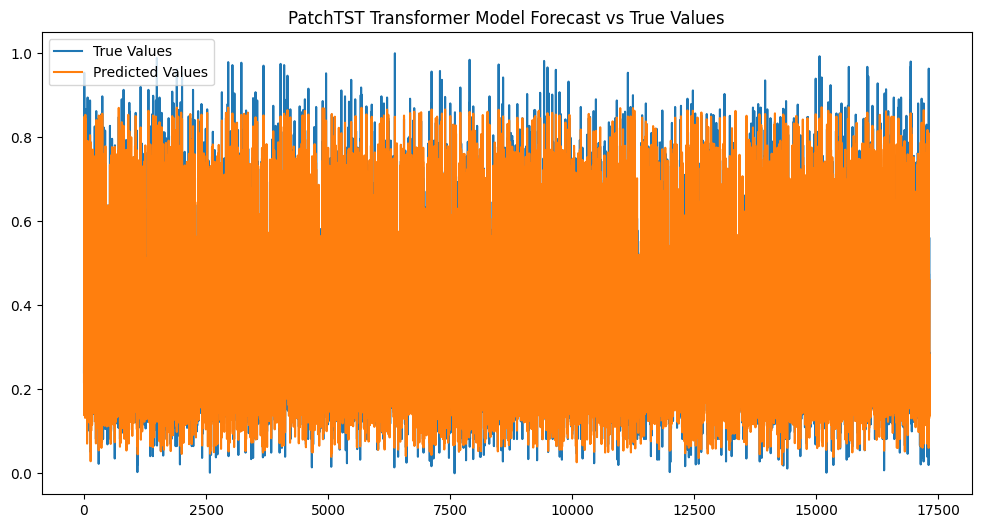

Results saved to ../predictions/patchTST_transformer_predictions.csv


In [16]:
#calculate metrics 
mse=mean_squared_error(true_values, predictions)
mae=mean_absolute_error(true_values, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# Plot the results for comparison
plt.figure(figsize=(12, 6))
plt.plot(true_values, label="True Values")
plt.plot(predictions, label="Predicted Values")
plt.legend()
plt.title("PatchTST Transformer Model Forecast vs True Values")
plt.show()

# Save the results for comparison
results = pd.DataFrame({
    "True Values": true_values.flatten(),
    "Predictions": predictions.flatten()
})

results.to_csv("../predictions/patchTST_transformer_predictions.csv", index=False)
print("Results saved to ../predictions/patchTST_transformer_predictions.csv")